# Import Libraries and Dataset

In [ ]:
!pip install fuzzy-c-means

     |████████████████████████████████| 10.9 MB 7.6 MB/s 
     |████████████████████████████████| 15.7 MB 35.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd

from fcmeans import FCM
import pylab
import time
%matplotlib inline
from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
#Read Dataset
df = pd.read_csv('https://raw.githubusercontent.com/hafidzali04/Hacktiv8-phase0/main/data/data_ihk.csv')
df.head()

,Date,IHK
0,2016-Jan,130.23
1,2016-Feb,130.66
2,2016-Mar,130.56
3,2016-Apr,129.89
4,2016-Mei,132.06


In [ ]:
df.shape #Melihat bentuk data

(71, 2)

In [ ]:
df.set_index('Date',inplace=True) #Menjadikan kolom Date sebagai index

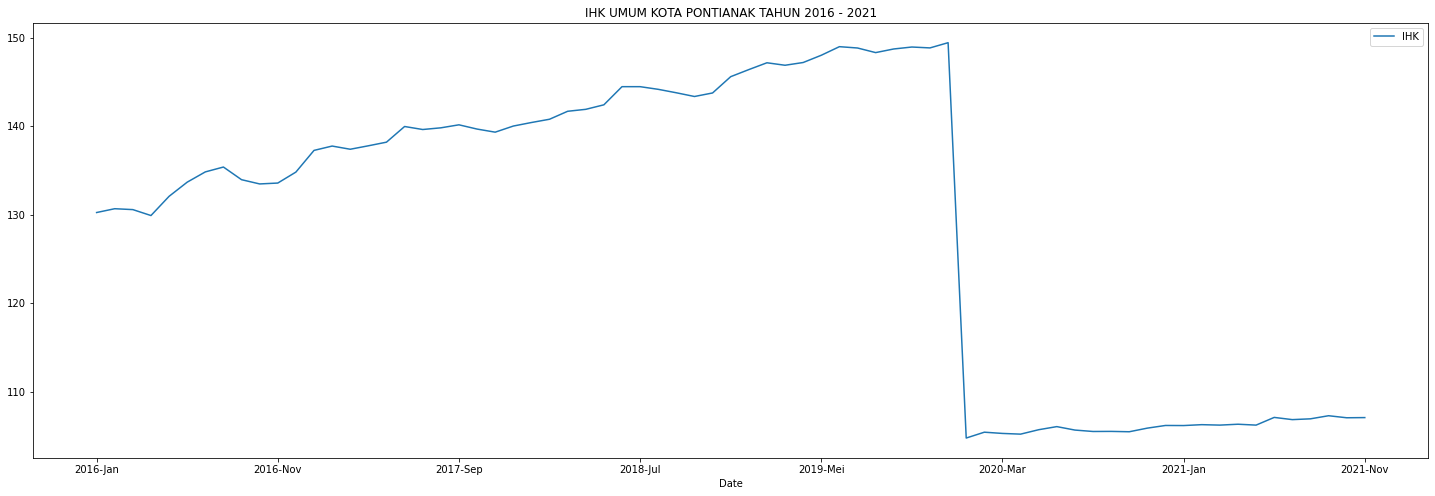

In [ ]:
pylab.rcParams['figure.figsize'] = (25, 8)
df.plot(kind='line', title='IHK UMUM KOTA PONTIANAK TAHUN 2016 - 2021')

* Bisa Terlihat bahwa IHK tahun 2019 ke 2020 terjadi penurunan IHK yang signifikan karena ada nya Covid

#SPLIT DATASET

In [ ]:
window=3 #Mengatur inputan data, per 3 bulan
X=[]
y=[]
for i in range(window,len(df)):
    X.append(df.IHK.iloc[i-window:i].values)
    y.append(df.IHK.iloc[i])
X=np.array(X)
y=np.array(y)

In [ ]:
#Normalisasi Data Menggunakan MinMax
minmax=MinMaxScaler().fit(X)
X_scaled=minmax.transform(X)

#Mengambil 80% data untuk dijadikan data Train dan 20% dijadikan data Test
train_size=0.8 
train_idx=int(train_size*len(X_scaled))

X_train=X_scaled[:train_idx]
X_test=X_scaled[train_idx:]

y_train=y[:train_idx]
y_test=y[train_idx:]

In [ ]:
# Melihat hasil splitting data

print('Presentase data yang digunakan untuk training data  :', '%.2f' % ((len(X_train)/len(X))*100), '%')
print('Presentase data yang digunakan untuk test data      :', '%.2f' % ((len(X_test)/len(X))*100), '%')
print()

print('Jumlah data training  :', X_train.shape[0])
print('Jumlah data test      :', X_test.shape[0])

Presentase data yang digunakan untuk training data  : 79.41 %
Presentase data yang digunakan untuk test data      : 20.59 %

Jumlah data training  : 54
Jumlah data test      : 14


# Design of FRBF Network
Since we need to train our FRBF network on different parameters, let us define one class that can be reused for all our requirements

In [ ]:
#Mencari Nilai tengah menggunakan Fuzzy C Means
#n_cluster menyesuaikan jumlah data train, semakin mendekati semakin bagus
#n_cluster !=data train
fcm = FCM(n_clusters=50, max_iter=100) 
fcm.fit(X_train)
fcm_centers = fcm.centers
print(fcm_centers.shape)

(50, 3)


In [ ]:
# RBF kernel function for the hidden nodes
def rbf(x, c, s):
    return np.exp( (np.linalg.norm(x-c)**2) * -1 / (2*s**2))

In [ ]:
class RBFN:
    #RBF Network Class
    def __init__(self, num_centres, lr=0.1, epochs=2200):
        """Initialization of hyperparameters"""
        self.lr = lr #learning rate
        self.epochs = epochs #number of epochs for training
        #randomly initialise weights
        self.w = np.random.randn(num_centres)
             
    def fit(self, train_ip, train_op, centres, std_dev):
        """Training phase"""
        self.hnodes = centres.shape[0]
        self.mse = []
        self.centres = centres
        self.stds = std_dev
        
        
        
        for epoch in range(self.epochs):
            #print("epoch: ",epoch+1,"/",self.epochs,"")
            calc_op = []
            
            for i in range(train_ip.shape[0]):
                
                
                a = np.array( [ rbf(train_ip[i], c, s) for c, s, in zip(centres, std_dev) ] )
                F = a.T.dot(self.w)
                calc_op.append(F)
 
                error = train_op[i] - F
                self.w = self.w + (self.lr * a * error)
            
            calc_op = np.array(calc_op)
            mse = np.square(y_train - calc_op).mean()
            #print("Training Mean Squared Error: ",mse)
            self.mse.append(mse)
            
        
    def predict(self, test_ip):
        """Prediction of unseen data"""
        test_op = []
        for i in range(test_ip.shape[0]):
            a = np.array( [ rbf(test_ip[i], c, s) for c, s, in zip(self.centres, self.stds) ] )
            F = a.T.dot(self.w)
            test_op.append(F)
            
        return np.array(test_op)

#Training

In [ ]:
#Mendefinisikan model Menggunakan RBFNN saja
rbfnn = RBFN(num_centres=X_train.shape[0])
%time rbfnn.fit(X_train, y_train, centres=X_train, std_dev=np.repeat(0.2,X_train.shape[0]))

CPU times: user 1min 8s, sys: 6.75 s, total: 1min 14s
Wall time: 1min 7s


In [ ]:
#Mendefinisikan model Menggunakan FuzzyRBFNN
frbfnn = RBFN(num_centres=fcm_centers.shape[0])
%time frbfnn.fit(train_ip=X_train, train_op=y_train, centres=fcm_centers, std_dev=np.repeat(0.2,km_centres.shape[0]))

CPU times: user 1min 2s, sys: 5.8 s, total: 1min 8s
Wall time: 1min 1s


In [ ]:
# Get the models forecast
train_rbfnn = rbfnn.predict(X_train)
train_frbfnn = frbfnn.predict(X_train)

#Evaluasi Training Model RBFNN
print('----Evaluasi Training Model RBFNN----')
mse = mean_squared_error(y_train,train_rbfnn)/100
print('MSE =', "{:.3f}".format(mse))
# MAPE
mape = np.mean(np.abs((y_train - train_rbfnn) / y_train))*100
print('MAPE =', "{:.2f}%".format(mape))


#Evaluasi Training Model FRBFNN
print('\n\n----Evaluasi Training Model FuzzyRBF----')
# MSE
mse = mean_squared_error(y_train,train_frbfnn)/100
print('MSE =', "{:.3f}".format(mse))

# MAPE
mape = np.mean(np.abs((y_train - train_frbfnn) / y_train))*100
print('MAPE =', "{:.2f}%".format(mape))

----Evaluasi Training Model RBFNN----
MSE = 5.661
MAPE = 12.80%


----Evaluasi Training Model FuzzyRBF----
MSE = 4.957
MAPE = 11.97%


In [ ]:
hasil_train = pd.DataFrame({'Date':df.index[:train_idx],'actual':y_train, 'Train RBFNN':train_rbfnn,'Train FuzzyRBFNN':train_frbfnn})
hasil_train.set_index('Date',inplace=True) 
hasil_train

,actual,Train RBFNN,Train FuzzyRBFNN
Date,,,
2016-Jan,129.89,119.080948,119.975215
2016-Feb,132.06,121.458796,121.856758
2016-Mar,133.66,121.455606,122.850899
2016-Apr,134.82,128.019396,129.162103
2016-Mei,135.37,159.935995,159.039799
2016-Jun,133.94,170.197164,168.456420
2016-Jul,133.46,180.920909,178.059624
2016-Aug,133.56,187.676329,184.466034
2016-Sep,134.80,180.960433,178.484869


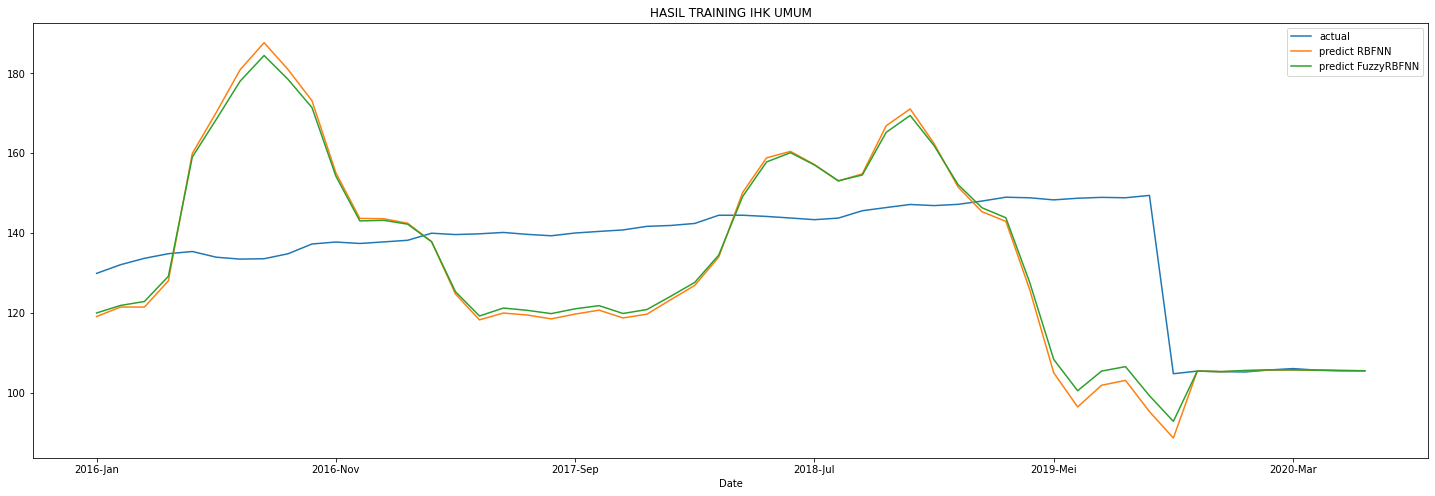

In [ ]:
pylab.rcParams['figure.figsize'] = (25, 8)
hasil_train.plot(kind='line', title='HASIL TRAINING IHK UMUM')

#Testing

In [ ]:
# forecast Menggunakan data test
test_rbfnn = rbfnn.predict(X_test)
test_frbfnn = frbfnn.predict(X_test)

#Evaluasi Training Model RBFNN
print('----Evaluasi Training Model RBFNN----')
mse = mean_squared_error(y_test,test_rbfnn)/100
print('MSE =', "{:.3f}".format(mse))
# MAPE
mape = np.mean(np.abs((y_test - test_rbfnn) / y_test))*100
print('MAPE =', "{:.2f}%".format(mape))


#Evaluasi Training Model FRBFNN
print('\n\n----Evaluasi Training Model FuzzyRBF----')
# MSE
mse = mean_squared_error(y_test,test_frbfnn)/100
print('MSE =', "{:.3f}".format(mse))

# MAPE
mape = np.mean(np.abs((y_test - test_frbfnn) / y_test))*100
print('MAPE =', "{:.2f}%".format(mape))


----Evaluasi Training Model RBFNN----
MSE = 0.105
MAPE = 2.32%


----Evaluasi Training Model FuzzyRBF----
MSE = 0.110
MAPE = 2.37%


In [ ]:
hasil_test = pd.DataFrame({'Date':df.index[train_idx:68],'actual':y_test, 'Test RBFNN':test_rbfnn,'Test FuzzyRBFNN':test_frbfnn})
hasil_test.set_index('Date',inplace=True) 
hasil_test

,actual,Test RBFNN,Test FuzzyRBFNN
Date,,,
2020-Jul,105.46,105.745703,105.766534
2020-Aug,105.87,105.781794,105.817748
2020-Sep,106.17,105.716944,105.740504
2020-Okt,106.16,105.467917,105.482568
2020-Nov,106.26,105.133435,105.109807
2020-Dec,106.21,104.805145,104.752779
2021-Jan,106.31,104.771845,104.720845
2021-Feb,106.21,104.616940,104.554983
2021-Mar,107.08,104.670445,104.614685


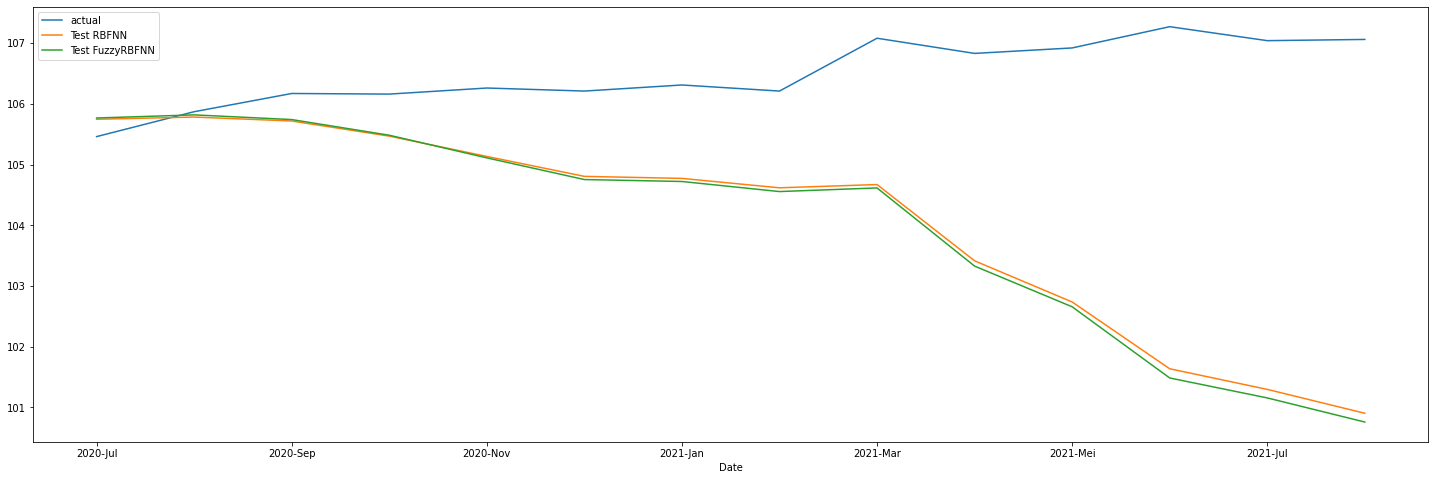

In [ ]:
pylab.rcParams['figure.figsize'] = (25, 8)
hasil_test.plot(kind='line')

## Best Model: 
### FRBF Network Lebih baik di training karena menghasilkan mse dan mape lebih kecil dari pada model RBFNN saja, dengan parameter seperti  0.1 Learning Rate , 2200 Epoch , and std_dev 0.2